# Load the Dataset

In [ ]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct

## Imports and Helper Functions

In [2]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from helper_functions import supervised_metrics
from sklearn import preprocessing
import string
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics

label_encoder = preprocessing.LabelEncoder()

root="/content/pubmed-rct/PubMed_20k_RCT"

In [3]:
#Metrics
def supervised_metrics(y_true, y_pred):
    """Meterics for a Supervised Learning model:"""
    print("Accuracy : {} %".format(metrics.accuracy_score(y_true, y_pred)*100))
    print("F1 Score : {}".format(metrics.f1_score(y_true, y_pred, average='weighted')))
    print("Recall : {}".format(metrics.recall_score(y_true, y_pred, average='weighted')))
    print("Precision : {}".format(metrics.precision_score(y_true, y_pred, average='weighted')))

#Confusion Matrix
def confusion_matrix_plot(y_true, y_pred, classes, figsize=(8,8)):
    """"Confusion Matrix for true values and predicted values"""
    cm = metrics.confusion_matrix(y_true, y_pred)
    cm = cm.astype('float') / cm.sum(axis=1)
    plt.figure(figsize = figsize)

    ax=sns.heatmap(cm, annot=True, cmap="crest")

    ax.set_xlabel("Predictions", labelpad=20)
    ax.xaxis.set_ticklabels(classes)

    ax.set_ylabel("True Values", labelpad=20)
    ax.yaxis.set_ticklabels(classes)

#Read The Files
def getlines(path):
  with open(path, "r") as f:
    return f.readlines()

#Pre-Process the Data
def getdata(path):
  input_lines = getlines(path)
  abstract_lines = ""
  abstract_samples = []
  
  for line in input_lines:
    if line.startswith("###"):
      abstract_id = line
      abstract_lines = ""
    elif line.isspace():
      abstract_line_split = abstract_lines.splitlines()

      # Iterate through each line in abstract and count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {}
        target_text_split = abstract_line.split("\t")
        line_data["target"] = target_text_split[0]
        line_data["text"] = target_text_split[1].lower()
        line_data["line_number"] = abstract_line_number
        line_data["total_lines"] = len(abstract_line_split) - 1
        abstract_samples.append(line_data)
    
    else:
      abstract_lines += line

  return abstract_samples

#Split words
def split_chars(text):
  return " ".join(list(text))

## Data Pre-Processing

### Pre-Process the Data to required Format

In [31]:
#Process the Data as a DataFrame
train_data=pd.DataFrame( getdata(os.path.join(root,"train.txt")) )
val_data=pd.DataFrame( getdata(os.path.join(root,"dev.txt")) )
test_data=pd.DataFrame( getdata(os.path.join(root,"test.txt")) )

#Get 'text' column alone
train_sentences = train_data["text"].tolist()
val_sentences = val_data["text"].tolist()
test_sentences = test_data["text"].tolist()

#One-Hot encode the 'labels'
ohe = OneHotEncoder(sparse=False)
train_labels= ohe.fit_transform(train_data["target"].to_numpy().reshape(-1, 1))
val_labels= ohe.fit_transform(val_data["target"].to_numpy().reshape(-1, 1))
test_labels= ohe.fit_transform(test_data["target"].to_numpy().reshape(-1, 1))

#Global variables
num_classes=len(test_data["target"].unique())
classes=test_data["target"].unique()

#One-Hot encode the 'line-number'
train_line_numbers = tf.one_hot(train_data["line_number"].to_numpy(), depth=15)
val_line_numbers = tf.one_hot(val_data["line_number"].to_numpy(), depth=15)
test_line_numbers = tf.one_hot(test_data["line_number"].to_numpy(), depth=15)

#One-Hot encode the 'total_lines'
train_total_lines = tf.one_hot(train_data["total_lines"].to_numpy(), depth=20)
val_total_lines = tf.one_hot(val_data["total_lines"].to_numpy(), depth=20)
test_total_lines = tf.one_hot(test_data["total_lines"].to_numpy(), depth=20)

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


### Character Tokenization and Embedding

In [5]:
#Split Chatacters
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]

#Length of sentences in terms of 'Number of Chatacters'
char_lens = [len(sentence) for sentence in train_sentences]
output_seq_char_len = int(np.percentile(char_lens, 95))

#Unique Alphabet
alphabet = string.ascii_lowercase + string.digits + string.punctuation

#Number of Tokens
NUM_CHAR_TOKENS = len(alphabet) + 2

#Character Tokenization
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,  
                                    output_sequence_length=output_seq_char_len,
                                    standardize="lower_and_strip_punctuation",
                                    name="char_vectorizer")

#Character Embedding
char_embed = layers.Embedding(input_dim=NUM_CHAR_TOKENS,
                              output_dim=25,
                              mask_zero=False,
                              name="char_embed")

#Adapt character vectorizer to training characters
char_vectorizer.adapt(train_chars)

### Tensorflow Hub Embedding

In [6]:
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")

### Converting to TensorFlow Datasets

In [7]:
#Train Dataset
train_pos_char_token_data = tf.data.Dataset.from_tensor_slices((train_line_numbers,
                                                                train_total_lines,
                                                                train_sentences,
                                                                train_chars))
train_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels)
train_dataset = tf.data.Dataset.zip((train_pos_char_token_data, train_pos_char_token_labels))
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Validation dataset
val_pos_char_token_data = tf.data.Dataset.from_tensor_slices((val_line_numbers,
                                                              val_total_lines,
                                                              val_sentences,
                                                              val_chars))
val_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels)
val_dataset = tf.data.Dataset.zip((val_pos_char_token_data, val_pos_char_token_labels))
val_dataset = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE) 

## Model

In [8]:
#TF-Hub Tokeinization Model
token_inputs=layers.Input(shape=[], dtype=tf.string, name="token_input")
token_embedding=tf_hub_embedding_layer(token_inputs)
token_outputs=layers.Dense(128, activation="relu")(token_embedding)
token_model=tf.keras.Model(token_inputs, token_outputs)

#Character Vectorization
char_inputs=layers.Input(shape=[], dtype=tf.string, name="char_input")
char_vector=char_vectorizer(char_inputs)
char_embedding=char_embed(char_vector)
char_outputs= layers.Bidirectional(layers.LSTM(25))(char_embedding)
char_model=tf.keras.Model(char_inputs, char_outputs)

#Line
line_number_inputs = layers.Input(shape=(15,), dtype=tf.int32, name="line_number_input")
x = layers.Dense(32, activation="relu")(line_number_inputs)
line_number_model = tf.keras.Model(inputs=line_number_inputs,
                                   outputs=x)

#Total Lines
total_lines_inputs = layers.Input(shape=(20,), dtype=tf.int32, name="total_lines_input")
y = layers.Dense(32, activation="relu")(total_lines_inputs)
total_line_model = tf.keras.Model(inputs=total_lines_inputs,
                                  outputs=y)

#Concatenate the Models
token_char_concat = layers.Concatenate(name="token_char_hybrid")([token_model.output, 
                                                                  char_model.output])
z = layers.Dense(256, activation="relu")(token_char_concat)
z = layers.Dropout(0.5)(z)

z = layers.Concatenate(name="token_char_positional_embedding")([line_number_model.output,
                                                                total_line_model.output,
                                                                z])
outputs = layers.Dense(num_classes, activation="softmax", name="output_layer")(z)

model=tf.keras.Model(inputs=[line_number_model.input, total_line_model.input, token_model.input, char_model.input], outputs=outputs)
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_input (InputLayer)        [(None,)]            0           []                               
                                                                                                  
 token_input (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 296)         0           ['char_input[0][0]']             
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   ['token_input[0][0]']      

In [9]:
model.compile(loss="categorical_crossentropy", optimizer="adam",metrics=["accuracy"])
model.fit(
     train_dataset,
     steps_per_epoch=int(0.1 * len(train_dataset)),
     epochs=10,
     validation_data=val_dataset,
     validation_steps=int(0.1 * len(val_dataset))
)

Epoch 1/10
562/562 [==============================] - 37s 41ms/step - loss: 0.7426 - accuracy: 0.7159 - val_loss: 0.5367 - val_accuracy: 0.7949
Epoch 2/10
562/562 [==============================] - 20s 35ms/step - loss: 0.4897 - accuracy: 0.8149 - val_loss: 0.4560 - val_accuracy: 0.8261
Epoch 3/10
562/562 [==============================] - 19s 34ms/step - loss: 0.4517 - accuracy: 0.8238 - val_loss: 0.4375 - val_accuracy: 0.8311
Epoch 4/10
562/562 [==============================] - 19s 35ms/step - loss: 0.4368 - accuracy: 0.8381 - val_loss: 0.4150 - val_accuracy: 0.8374
Epoch 5/10
562/562 [==============================] - 18s 32ms/step - loss: 0.4145 - accuracy: 0.8455 - val_loss: 0.4038 - val_accuracy: 0.8491
Epoch 6/10
562/562 [==============================] - 20s 36ms/step - loss: 0.4187 - accuracy: 0.8421 - val_loss: 0.3896 - val_accuracy: 0.8497
Epoch 7/10
562/562 [==============================] - 18s 32ms/step - loss: 0.3965 - accuracy: 0.8491 - val_loss: 0.3923 - val_accuracy:

945/945 [==============================] - 20s 22ms/step
Accuracy : 85.83344366476896 %
F1 Score : 0.85674298397954
Recall : 0.8583344366476897
Precision : 0.8643158939972017


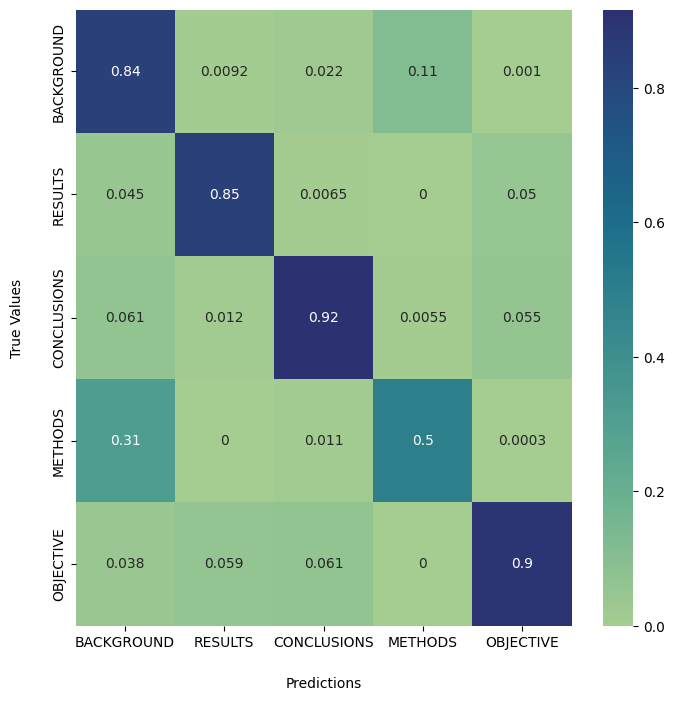

In [37]:
#Prediction
y_pred=model.predict(val_dataset, verbose=1)
y_pred=tf.math.argmax(tf.math.round(y_pred), axis=1)
y_true=label_encoder.fit_transform(val_data["target"])

#Evaluate Metrics
supervised_metrics(y_true, y_pred)

#Plot Confusion Matrix
confusion_matrix_plot(y_true, y_pred, classes)